# Google Trends: data exploration

**notas**

TODO) 1) DEFINIR A VARIAVEL Y COMO SENDO O LOG DA PRIMEIRA DIFERENCA ENTRE OS RETORNOS DO SP FUTURO

TODO) 2) DEFINIR A VARIAVEL X COMO SENDO A PRIMEIRA DIFERENCA DO TREND DAS PALAVRAS

TODO) 3) FEATURE SELECTION 1) ESCOLHER AS PALAVARS COM MAIOR R2 (REGRESSAO SIMPLES)

TODO) 4) FEATURE SELECTION 2) ESCOLHER AS PALAVARS COM MAIOR R2



1) Como nós não temos os dados de  "[Quantifying the semantics of search behavior before stock market moves](https://www.pnas.org/content/111/32/11600)" não conseguimos reproduzir os resultados. A API do google retorna dados com frequencia mensal quando colocamos o timeframe `2004-01-04 2012-12-16`.

### All Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob
from IPython.display import display, HTML, Markdown
from word_list.basic import politics1, politics2
from word_list.basic import business
from plot.ts import plot_acf
from plot.lr import simple_lr_plot
from sklearn.model_selection import TimeSeriesSplit

## Loading market data and defining return variable

In [2]:
asset = "es1"
market_path = os.path.join('data','market',"{}.txt".format(asset))
df_market = pd.read_csv(market_path, sep='\t')
close_price_column = 'PX_LAST'
date_column='date'
df_market.loc[:, date_column] = pd.to_datetime(df_market[date_column])
df_market = df_market.set_index(date_column)
close = df_market[[close_price_column]].dropna()
close = close.pct_change().dropna()
return_column = "{}_returns".format(asset)
close.columns = [return_column]
close.head(5)

,es1_returns
date,
2000-01-04,-0.037501
2000-01-05,0.001241
2000-01-06,-0.006724
2000-01-07,0.039712
2000-01-10,0.010443


## Create trends df from daily information

In [3]:
trends_path = os.path.join('data','daily_trend',"*.csv")
daily_dfs_path =  glob(trends_path)
daily_dfs_path.sort()
daily_dfs = [pd.read_csv(path) for path in daily_dfs_path]
daily_dfs_names = [i.split("/")[2] for i in daily_dfs_path]
daily_dfs_names = [i.split(".")[0] for i in daily_dfs_names]

trends_df = []
for name, df in zip(daily_dfs_names, daily_dfs):
    df.index = pd.to_datetime(df.date)
    ts = df[name]
    new_name = name.replace(" ", "_")
    ts.name = new_name
    trends_df.append(ts)

final_date = "2020-07-25"
trends_df = pd.concat(trends_df,1)
trends_df = trends_df[:final_date]
trends_df = trends_df.fillna(0.0)
word_features = list(trends_df.columns)
word_features.sort()
trends_df = trends_df[word_features]

Curme_first = "2004-01-04"
Curme_last = "2012-12-16"

trends_df_train = trends_df[Curme_first:Curme_last]
trends_df_test = trends_df[Curme_last:]
display(Markdown("### Google trends data (training: 2004 -- 2012)"))
display(HTML(trends_df_train.head(5).to_html()))
display(Markdown("#### training data shape = {}".format(trends_df_train.shape))) 

### Google trends data (training: 2004 -- 2012)

,BUY_AND_HOLD,DOW_JONES,act,arts,bank,banking,blacklist,bonds,bubble,business,buy,cancer,car,carolina,case,cash,ceo,chance,college,color,committee,community,companies,conflict,consume,consumption,conty,corporation,council,county,court,crash,credit,crisis,culture,debt,default,democratic,derivatives,development,district,dividend,dow_jones,earnings,earths,economic,economics,economy,elected,election,elections,energy,environment,fed,federal,finance,financial,fine,firm,fond,food,forex,founded,freedom,fun,gain,gains,garden,georgia,global,gold,government,governor,greed,growth,happy,headlines,health,hedge,holiday,home,house,housing,illinois,inc,industry,inflation,invest,investment,judge,justice,kentucky,kitchen,labor,law,legal,leverage,lifestyle,loss,ltd,management,market,marketing,markets,marriage,massachusetts,media,members,metals,million,minister,ministry,missouri,money,movement,movie,nasdaq,notability,nyse,office,ohio,oil,opportunity,ore,party,pennsylvania,police,political,politics,portfolio,present,president,products,profit,project,rare,religion,representatives,republican,restaurant,return,returns,revenue,rich,rights,ring,risk,seats,secretary,security,sell,selling,senate,served,service,services,short,social,society,stats,stock,stocks,success,technology,tennessee,texas,tourism,trader,train,transaction,travel,unemployment,union,vermont,vermount,virginia,voter,voters,votes,war,washington,water,william,winsconsin,wisconsin,world,york
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2004-01-04,1.0,1.0,18.0,26.0,57.0,5.0,0.0,6.0,6.0,51.0,81.0,17.0,84.0,51.0,26.0,10.0,1.0,3.0,68.0,27.0,3.0,50.0,18.0,4.0,1.0,3.0,0.0,13.0,10.0,67.0,27.0,10.0,53.0,3.0,7.0,5.0,7.0,8.0,2.0,19.0,31.0,2.0,1.0,1.0,0.0,5.0,3.0,4.0,1.0,4.0,1.0,18.0,4.0,3.0,29.0,5.0,17.0,13.0,4.0,0.0,61.0,1.0,1.0,8.0,18.0,4.0,2.0,23.0,46.0,12.0,30.0,21.0,2.0,1.0,8.0,12.0,1.0,55.0,1.0,21.0,100.0,86.0,11.0,43.0,28.0,9.0,1.0,1.0,8.0,3.0,8.0,14.0,26.0,13.0,46.0,11.0,1.0,2.0,14.0,5.0,26.0,25.0,9.0,3.0,19.0,26.0,43.0,6.0,3.0,5.0,3.0,3.0,20.0,29.0,3.0,83.0,2.0,0.0,1.0,62.0,60.0,24.0,3.0,1.0,41.0,26.0,32.0,10.0,2.0,2.0,3.0,10.0,27.0,2.0,31.0,5.0,7.0,2.0,5.0,38.0,24.0,1.0,7.0,7.0,14.0,35.0,6.0,6.0,4.0,30.0,11.0,6.0,2.0,1.0,79.0,38.0,22.0,21.0,32.0,8.0,26.0,6.0,3.0,24.0,21.0,70.0,8.0,9.0,26.0,0.0,57.0,10.0,37.0,16.0,1.0,56.0,1.0,1.0,1.0,60.0,68.0,48.0,34.0,1.0,29.0,87.0,85.0
2004-01-05,0.0,1.0,21.0,29.0,50.0,2.0,0.0,5.0,3.0,52.0,71.0,23.0,82.0,47.0,26.0,10.0,4.0,2.0,100.0,34.0,4.0,88.0,19.0,2.0,0.0,5.0,0.0,10.0,11.0,71.0,28.0,14.0,55.0,2.0,9.0,6.0,5.0,9.0,0.0,19.0,58.0,2.0,2.0,3.0,1.0,6.0,5.0,3.0,2.0,5.0,2.0,11.0,6.0,2.0,25.0,5.0,18.0,6.0,8.0,0.0,57.0,0.0,3.0,8.0,23.0,5.0,1.0,20.0,38.0,10.0,33.0,25.0,5.0,1.0,6.0,8.0,1.0,54.0,2.0,21.0,87.0,79.0,11.0,36.0,30.0,7.0,4.0,1.0,10.0,5.0,5.0,14.0,22.0,11.0,52.0,16.0,0.0,2.0,15.0,4.0,36.0,22.0,13.0,3.0,34.0,24.0,43.0,5.0,1.0,4.0,3.0,6.0,20.0,29.0,6.0,73.0,3.0,0.0,2.0,54.0,49.0,23.0,4.0,2.0,30.0,21.0,30.0,7.0,5.0,3.0,2.0,13.0,29.0,2.0,28.0,5.0,7.0,2.0,6.0,30.0,22.0,2.0,5.0,8.0,12.0,37.0,2.0,4.0,3.0,35.0,7.0,2.0,2.0,2.0,70.0,44.0,20.0,17.0,33.0,6.0,29.0,6.0,3.0,21.0,19.0,66.0,12.0,13.0,18.0,2.0,60.0,4.0,31.0,12.0,0.0,57.0,2.0,2.0,2.0,64.0,67.0,51.0,39.0,0.0,30.0,91.0,70.0
2004-01-06,0.0,2.0,31.0,30.0,87.0,7.0,0.0,4.0,4.0,86.0,66.0,27.0,78.0,57.0,26.0,11.0,3.0,2.0,89.0,32.0,9.0,87.0,32.0,3.0,1.0,1.0,1.0,37.0,19.0,96.0,48.0,10.0,74.0,3.0,13.0,5.0,7.0,7.0,1.0,33.0,62.0,2.0,2.0,1.0,1.0,10.0,7.0,6.0,1.0,7.0,2.0,24.0,8.0,6.0,54.0,16.0,36.0,8.0,7.0,2.0,62.0,1.0,2.0,7.0,17.0,4.0,1.0,21.0,62.0,19.0,23.0,36.0,6.0,1.0,11.0,10.0,1.0,94.0,2.0,28.0,87.0,85.0,12.0,50.0,56.0,14.0,2.0,2.0,10.0,4.0,9.0,16.0,16.0,16.0,66.0,22.0,0.0,3.0,13.0,10.0,59.0,32.0,21.0,5.0,17.0,34.0,42.0,6.0,3.0,5.0,1.0,6.0,25.0,27.0,4.0,45.0,3.0,0.0,2.0,100.0,82.0,27.0,2.0,1.0,36.0,34.0,35.0,12.0,4.0,5.0,2.0,18.0,37.0,5.0,38.0,3.0,5.0,4.0,7.0,47.0,15.0,2.0

#### training data shape = (3270, 187)

## Category Trend

We can aggregate the words in major categories. Here we use the categories **Politics1**, **Politics2** and **Business** (first defined in  CURME et al. [Quantifying the semantics of search behavior before stock market moves](https://www.pnas.org/content/111/32/11600))

### Trend over time

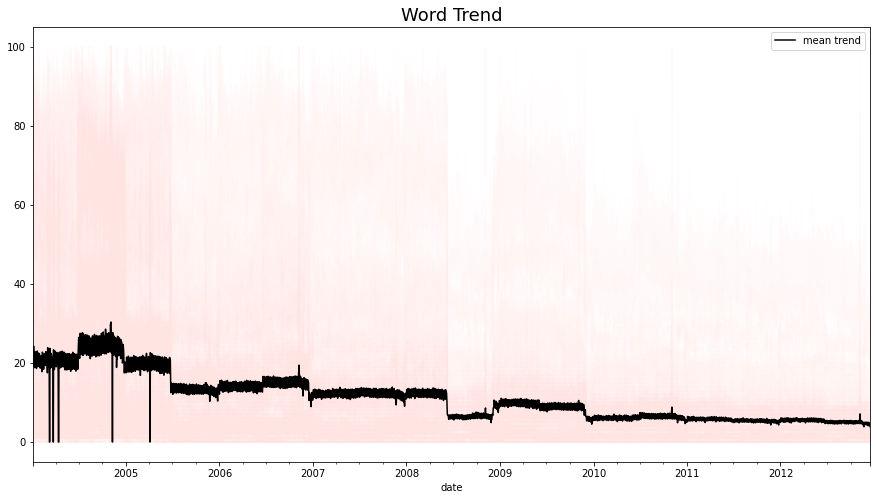

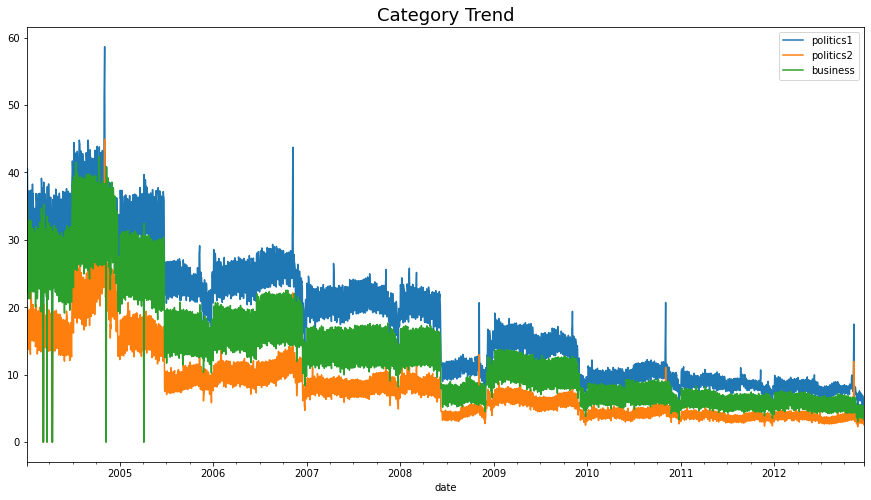

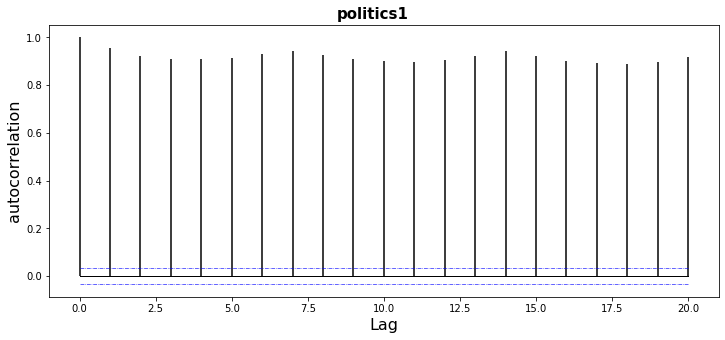

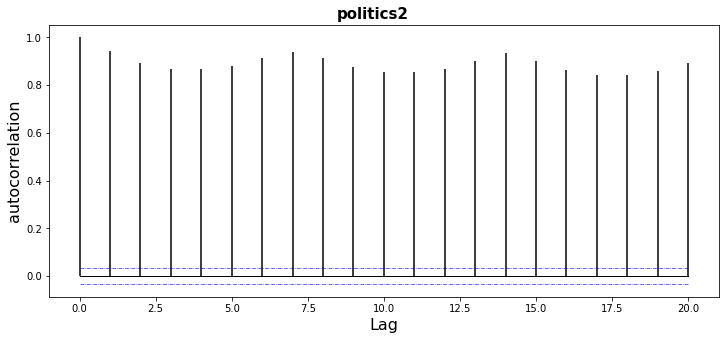

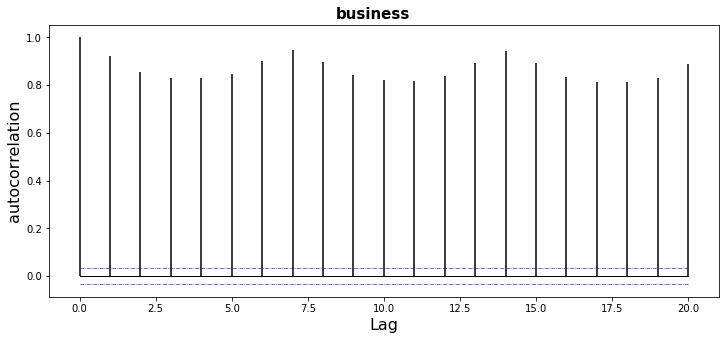

In [4]:
trends_df_p = trends_df_train.copy()
trends_df_p.columns = [""]* trends_df_p.shape[1]

politics1_ts = trends_df_train[politics1].mean(1)
politics1_ts.name = "politics1"
politics2_ts = trends_df_train[politics2].mean(1)
politics2_ts.name = "politics2"
business_ts = trends_df_train[business].mean(1)
business_ts.name = "business"

display(Markdown("### Trend over time"))
fig, ax = plt.subplots(figsize=(15,8))
trends_df_p.plot(ax=ax,legend=False,alpha= 0.05,  color="mistyrose");
trends_df_train.mean(1).plot(ax=ax,legend=False, color="k", label="mean trend");
ax.set_title("Word Trend", fontsize=18);
ax.legend(loc="best");


fig, ax = plt.subplots(figsize=(15,8))
politics1_ts.plot(ax=ax);
politics2_ts.plot(ax=ax);
business_ts.plot(ax=ax);
ax.set_title("Category Trend", fontsize=18);
ax.legend(loc="best");

plot_acf(politics1_ts, lag_range=21, out_path=None)
plot_acf(politics2_ts, lag_range=21, out_path=None)
plot_acf(business_ts, lag_range=21, out_path=None)

## Feature Correlation

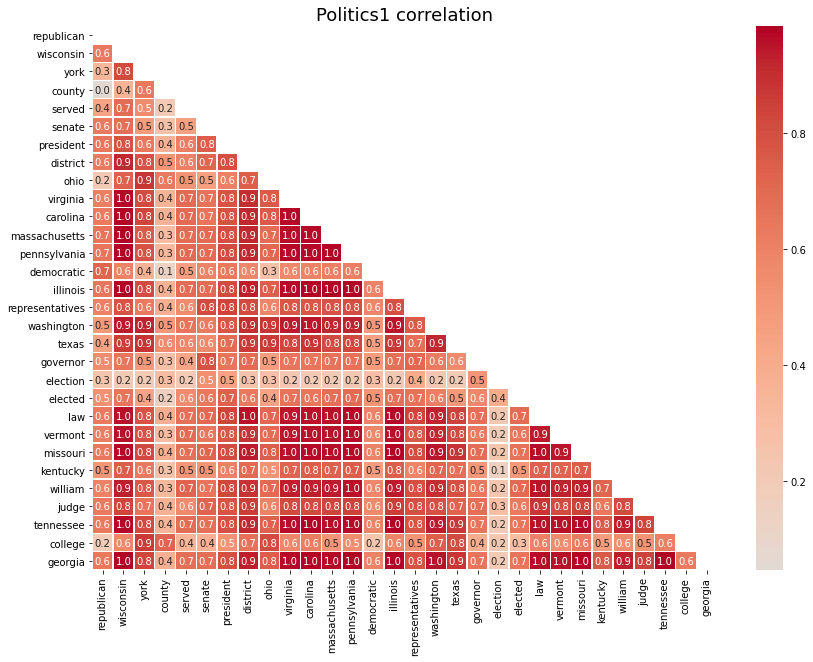

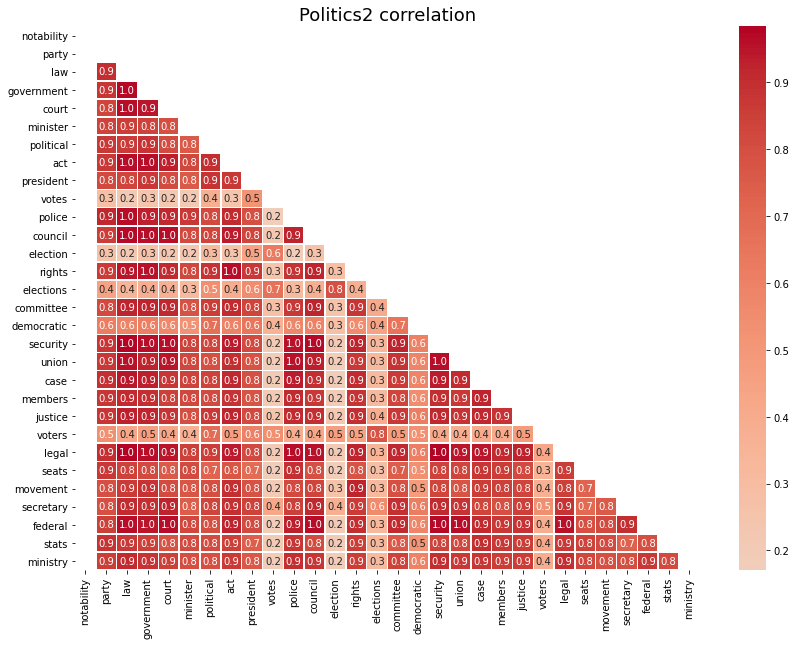

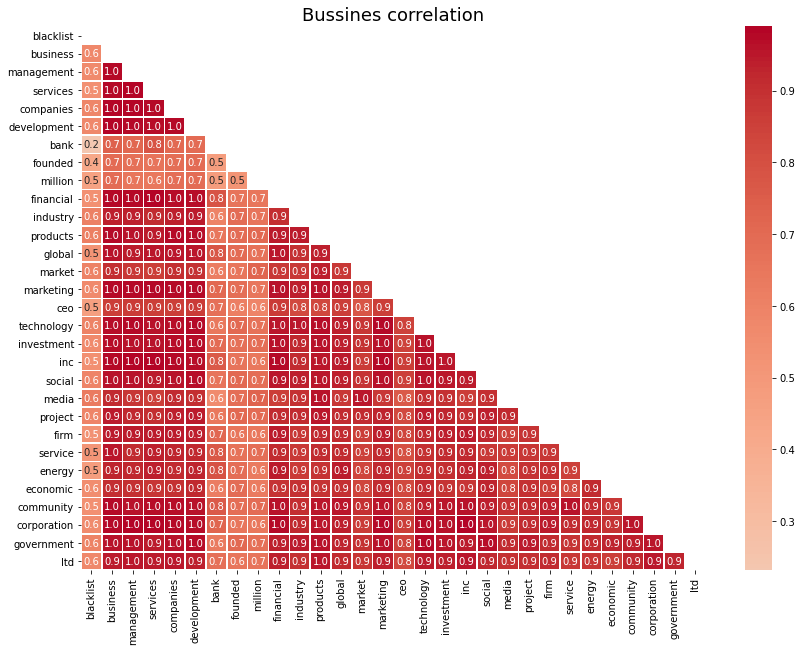

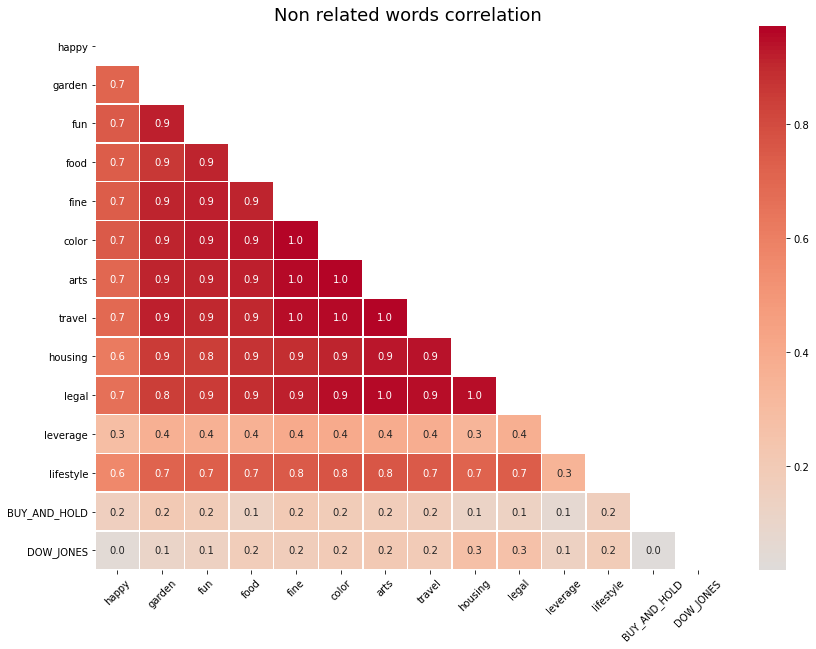

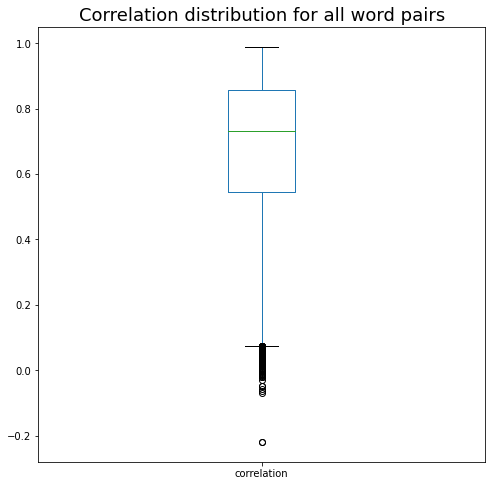

In [5]:
corr = trends_df_train[politics1].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

fig, ax = plt.subplots(figsize=(14,10))
ax.set_title("Politics1 correlation", fontsize=18)
sns.heatmap(corr, mask=mask, cmap="coolwarm", center=0, linewidths=0.5, annot=True, fmt=".1f", ax=ax);
plt.xticks(rotation=90);


corr = trends_df_train[politics2].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

fig, ax = plt.subplots(figsize=(14,10))
ax.set_title("Politics2 correlation", fontsize=18)
sns.heatmap(corr, mask=mask, cmap="coolwarm", center=0, linewidths=0.5, annot=True, fmt=".1f", ax=ax);
plt.xticks(rotation=90);


corr = trends_df_train[business].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

fig, ax = plt.subplots(figsize=(14,10))
ax.set_title("Bussines correlation", fontsize=18)
sns.heatmap(corr, mask=mask, cmap="coolwarm", center=0, linewidths=0.5, annot=True, fmt=".1f", ax=ax);
plt.xticks(rotation=90);

non_related_words = ["happy", "garden", "fun",
                     "food", "fine", "color",
                     "arts", "travel", "housing",
                     "legal", "leverage", "lifestyle",
                     "BUY_AND_HOLD", "DOW_JONES"]

corr = trends_df_train[non_related_words].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

fig, ax = plt.subplots(figsize=(14,10))
ax.set_title("Non related words correlation", fontsize=18)
sns.heatmap(corr, mask=mask, cmap="coolwarm", center=0, linewidths=0.5, annot=True, fmt=".1f", ax=ax);
plt.xticks(rotation=45);

corr = trends_df_train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
corr_df = pd.DataFrame(corr.mask(cond=mask).values.flatten()).dropna()
corr_df.columns = ["correlation"]
fig, ax = plt.subplots(figsize=(8,8))
corr_df.boxplot(ax=ax, grid=False);
ax.set_title(r"Correlation distribution for all word pairs", fontsize=18);

## Curme features 1

> To quantify changes in information-gathering behavior, we compute the relative change in search volume 

\begin{equation}
\Delta n(t, \Delta t) = n(t) − N(t − 1,  \Delta t)
\end{equation}

with 

\begin{equation}
N(t − 1, \Delta t) = (n(t − 1) + n(t − 2) + . . . + n(t − \Delta t))/\Delta t
\end{equation}



This is just the trend in the day $t$ minus the rolling mean in the past $\Delta t$ days (the rolling mean does not inclued day $t$).

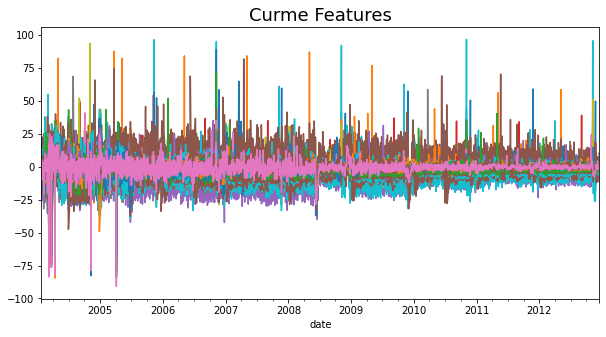

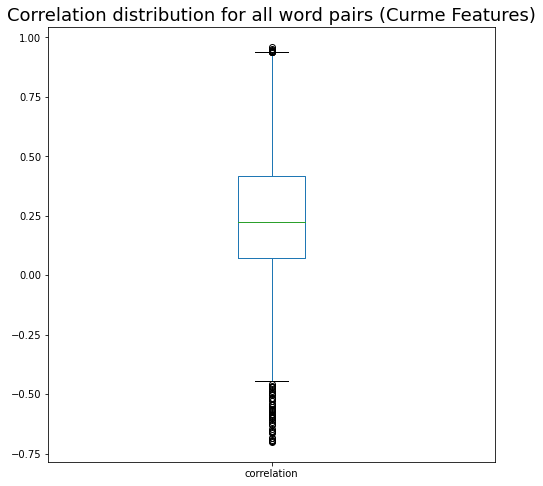

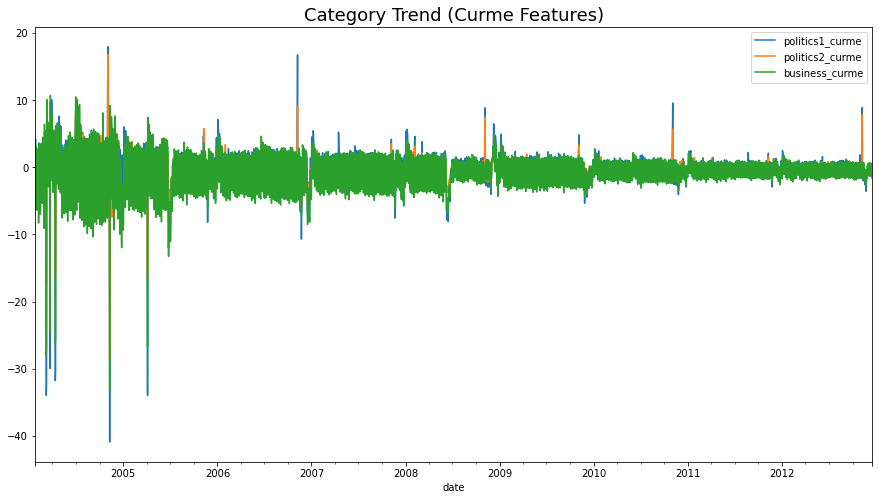

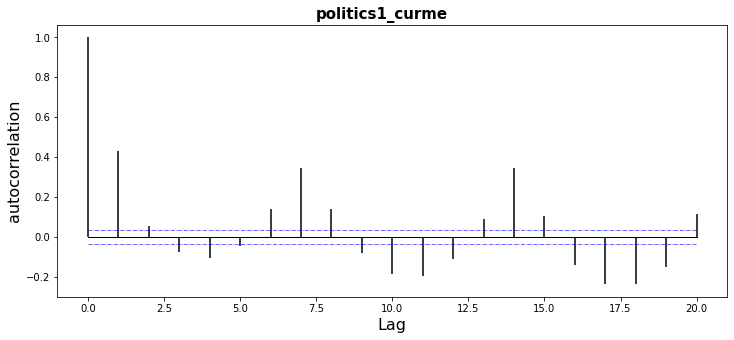

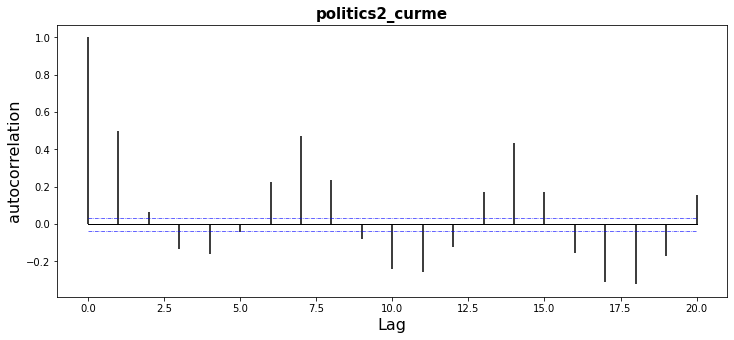

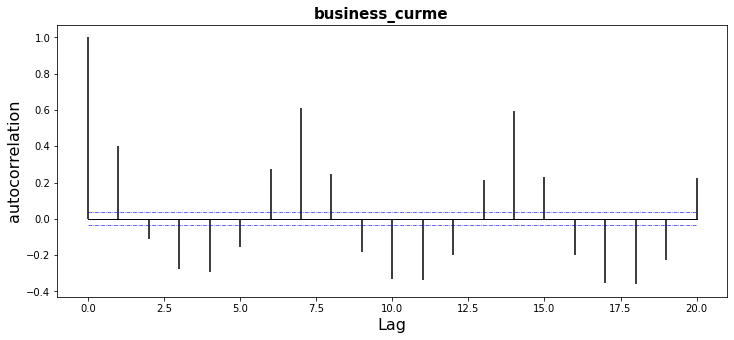

In [6]:
# using all data
delta_t = 3*7
curme_df = trends_df_train.copy()

# using the same frequency as the paper
# delta_t = 2
# curme_df = trends_df_train.resample("W").first()

curme_df = curme_df - curme_df.rolling(delta_t).mean().shift(1)
curme_df = curme_df.dropna()
fig, ax = plt.subplots(figsize=(10,5))
curme_df.plot(legend=False, ax=ax);
ax.set_title(r"Curme Features", fontsize=18);

corr = curme_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
corr_df = pd.DataFrame(corr.mask(cond=mask).values.flatten()).dropna()
corr_df.columns = ["correlation"]
fig, ax = plt.subplots(figsize=(8,8))
corr_df.boxplot(ax=ax, grid=False);
ax.set_title(r"Correlation distribution for all word pairs (Curme Features)", fontsize=18);

politics1_curme = curme_df[politics1].mean(1)
politics1_curme.name = "politics1_curme"
politics2_curme = curme_df[politics2].mean(1)
politics2_curme.name = "politics2_curme"
business_curme = curme_df[business].mean(1)
business_curme.name = "business_curme"

fig, ax = plt.subplots(figsize=(15,8))
politics1_curme.plot(ax=ax);
politics2_curme.plot(ax=ax);
business_curme.plot(ax=ax);
ax.set_title("Category Trend (Curme Features)", fontsize=18);
ax.legend(loc="best");

plot_acf(politics1_curme, lag_range=21, out_path=None)
plot_acf(politics2_curme, lag_range=21, out_path=None)
plot_acf(business_curme, lag_range=21, out_path=None)

### chosing $\Delta t$

> We find that terms within the Business category result in significant values of R for values of Δt of 2–15 wk (all Ws ≥ 19,278, all Ps < 0.05), with the exceptions of
Δt = 4 wk and Δt = 12 wk. Terms within the category Politics I result in significant returns for Δt = 2–15 wk (all Ws ≥ 20,422, all
Ps < 0.05), with the exceptions of Δt = 4, 5, and 7 wk.

**We can create an experiment by looking at the difference choice of $\Delta t$ and the correlation between the generated feature and the intrument returns**

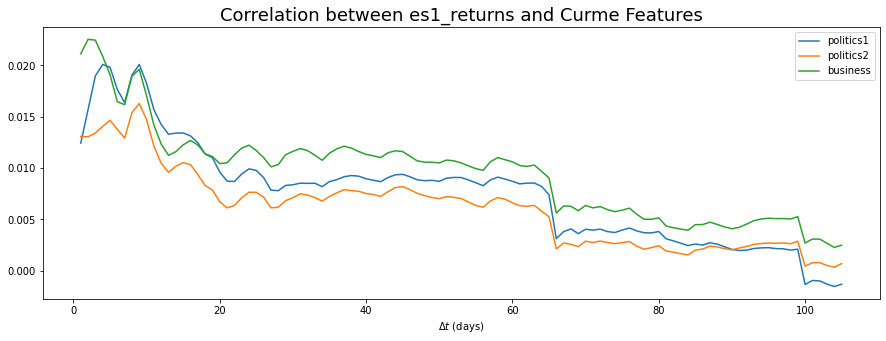

In [7]:
deltas = range(1, (15*7) + 1)
politics1_corrs  = []
politics2_corrs = []
business_corrs = []


for delta_t in deltas:

    curme_df = trends_df_train.copy()
    curme_df = curme_df - curme_df.rolling(delta_t).mean().shift(1)
    curme_df = curme_df.dropna()
    merged_df = pd.merge_asof(curme_df, close, left_index=True, right_index=True)
    merged_df.loc[:, "es1_returns"] = merged_df.es1_returns.shift(-1)
    merged_df = merged_df.dropna()
    merged_df.loc[:, "politics1_curme"] = merged_df[politics1].mean(1)
    merged_df.loc[:, "politics2_curme"] = merged_df[politics2].mean(1)
    merged_df.loc[:, "business_curme"] = merged_df[business].mean(1)
    columns = [return_column, "politics1_curme", "politics2_curme", "business_curme"]
    merged_df = merged_df[columns]
    p1_corr = merged_df.corr().loc[return_column, "politics1_curme"]
    p2_corr = merged_df.corr().loc[return_column, "politics2_curme"]
    b_corr = merged_df.corr().loc[return_column, "business_curme"]

    politics1_corrs.append(p1_corr)
    politics2_corrs.append(p2_corr)
    business_corrs.append(b_corr)

corrs = np.stack([politics1_corrs, politics2_corrs, business_corrs]).T
corrs = pd.DataFrame(corrs, columns = ["politics1", "politics2", "business"],index= deltas)
corrs.index.name = r"$\Delta t$ (days)"

fig, ax = plt.subplots(figsize=(15,5))
corrs.plot(ax=ax)
ax.set_title("Correlation between {} and Curme Features".format(return_column), fontsize=18);

## Curme features 2

> This approach also permits us to explore relationships between the magnitude of the change in search volume and the magnitude of the subsequent return, in addition to its sign. At
each week $t$ we monitor the mean relative change in search volume:

\begin{equation}
x_t  = \frac{\Delta n(t, \Delta t)}{N(t − 1, \Delta t)},
\end{equation}

for the Politics I, Politics II, and Business topics.


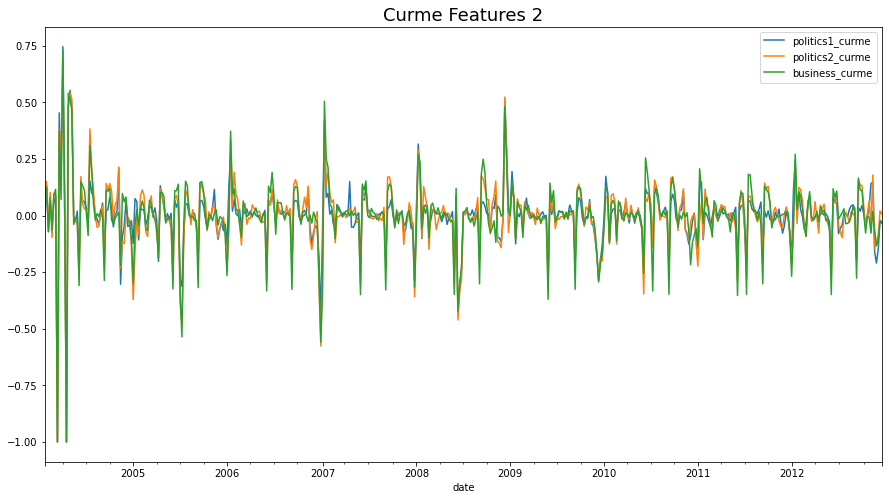

In [8]:
# using all data
delta_t = 3
curme_df = trends_df_train.resample("W").first()
# curme_df = trends_df_train.copy()
curme_df.loc[:, "politics1_curme"] = curme_df[politics1].mean(1)
curme_df.loc[:, "politics2_curme"] = curme_df[politics2].mean(1)
curme_df.loc[:, "business_curme"] = curme_df[business].mean(1)
columns = ["politics1_curme", "politics2_curme", "business_curme"]
curme_df = curme_df[columns]
rolling_mean = curme_df.rolling(delta_t).mean().shift(1) 
curme_df = (curme_df - rolling_mean) / rolling_mean
curme_df = curme_df.dropna()

fig, ax = plt.subplots(figsize=(15,8))
curme_df.plot(legend=True, ax=ax);
ax.set_title(r"Curme Features 2", fontsize=18);

### Applying simple linear regression

> We regress the percentage return of the SPXT in the subsequent week, $r_{t+1} ≡ [(p(t + 1) − p(t))/p(t)]·100\%$ against this signal. We also include the S&P 500 Volatility Index
(VIX) as a regressor:

\begin{equation}
r_{t+1} = \beta_0 + \beta_1 x_t + \beta_2 VIX_t + \epsilon_t ;
\end{equation}

where $\epsilon_t$ is an error term.

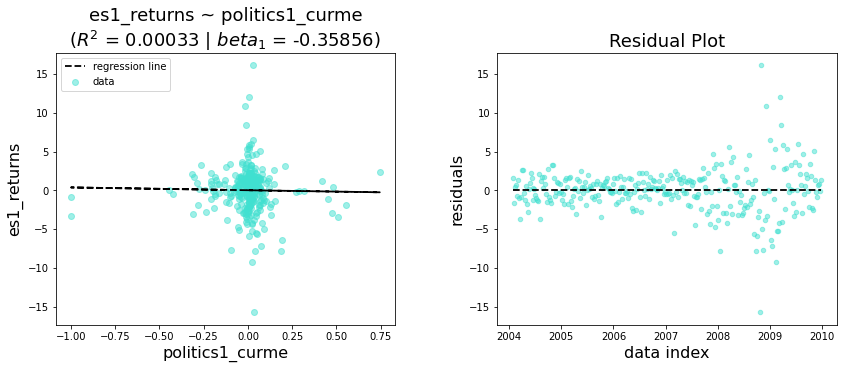

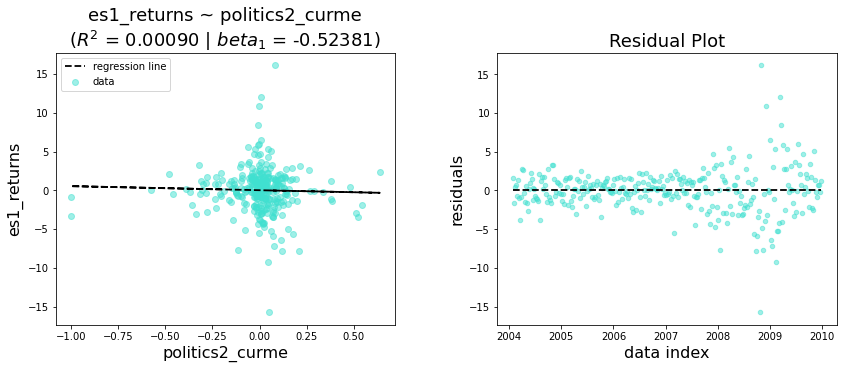

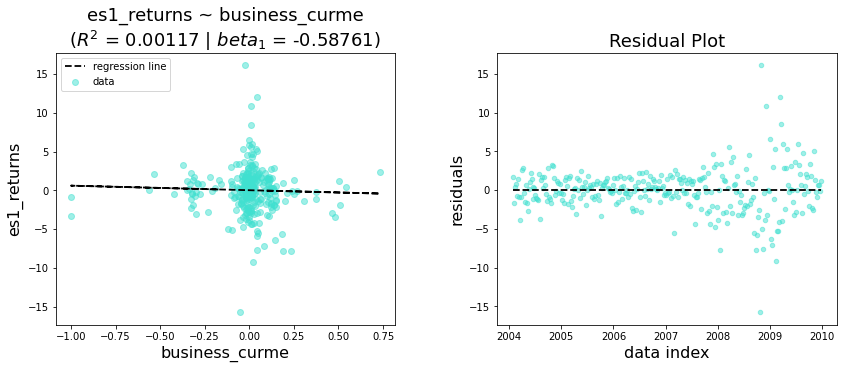

In [9]:
# Merging trend diff data and market data
close_week = df_market[[close_price_column]].dropna()
close_week = close_week.resample("W").first()
close_week = close_week.pct_change().dropna() * 100
return_column = "{}_returns".format(asset)
close_week.columns = [return_column]

merged_df = pd.merge_asof(curme_df, close_week, left_index=True, right_index=True)
merged_df.loc[:, "es1_returns"] = merged_df.es1_returns.shift(-1)
merged_df = merged_df.dropna()



tscv = TimeSeriesSplit(n_splits=2)
for train_index, test_index in tscv.split(merged_df):
    df_train = merged_df.iloc[train_index]
    df_test = merged_df.iloc[test_index]


simple_lr_plot(df=df_train,
               target_column=return_column,
               feature_column="politics1_curme")

simple_lr_plot(df=df_train,
               target_column=return_column,
               feature_column="politics2_curme")

simple_lr_plot(df=df_train,
               target_column=return_column,
               feature_column="business_curme")

> Curme et al. (2014) went a step further in clustering search terms tracked through
Google Trends by topics to find that there existed a lagged negative relationship
between number of searches in politics- and finance-related topics and the stock market
movements. More specifically, they found that when there was an increase in online
interest in politics- or finance-related topics, the stock market would be expected to
fall in the following periods. Such a relationship could not be found for other semantic
topics. The identified links were found from backtesting a trade strategy from 2004
to 2012, in which a decrease in the number of searches for certain topics served as a
buy signal (with the converse—increase in the number of searches for topics—would
be a sell signal) for the S&P 500 index.

## Data transformation by differencing


For each word $w$, ${X^{w}}_t$ is the associated trend series. The $k$ difference is define as:

\begin{equation}
{D^{w}}_t = {X^{w}}_t - {X^{w}}_{t-k}
\end{equation}

In [10]:
k = 1
trends_df_train_diff  = trends_df_train.diff(k).dropna()

## Looking at correlation of the transformed data

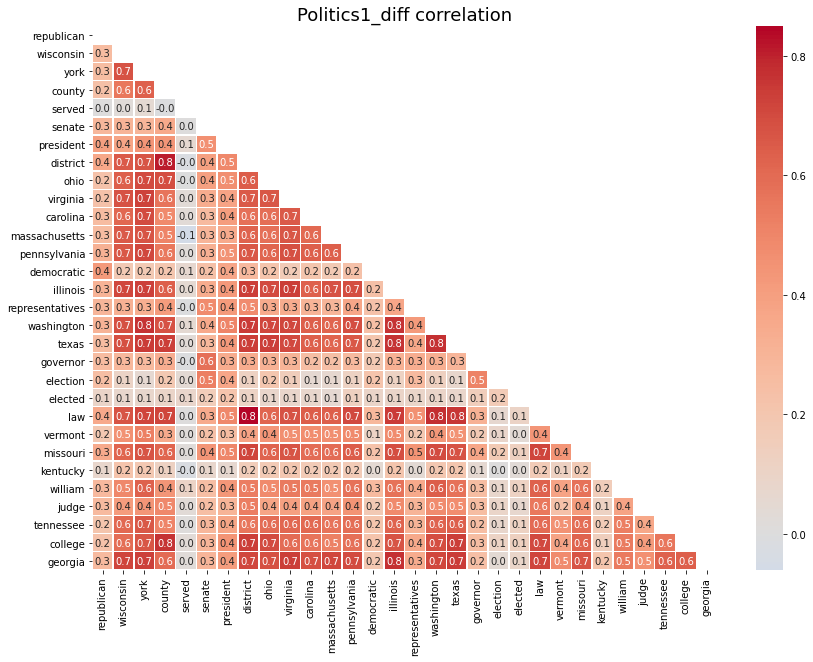

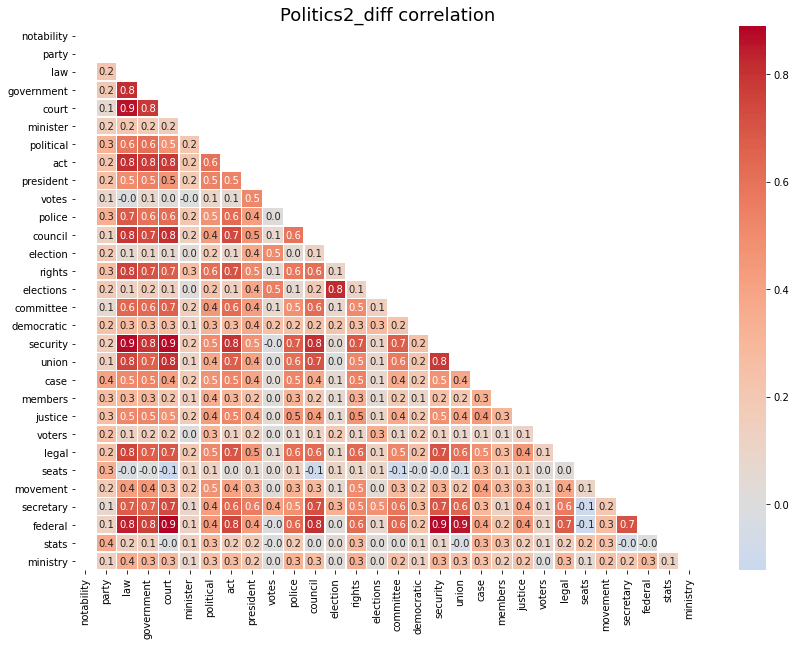

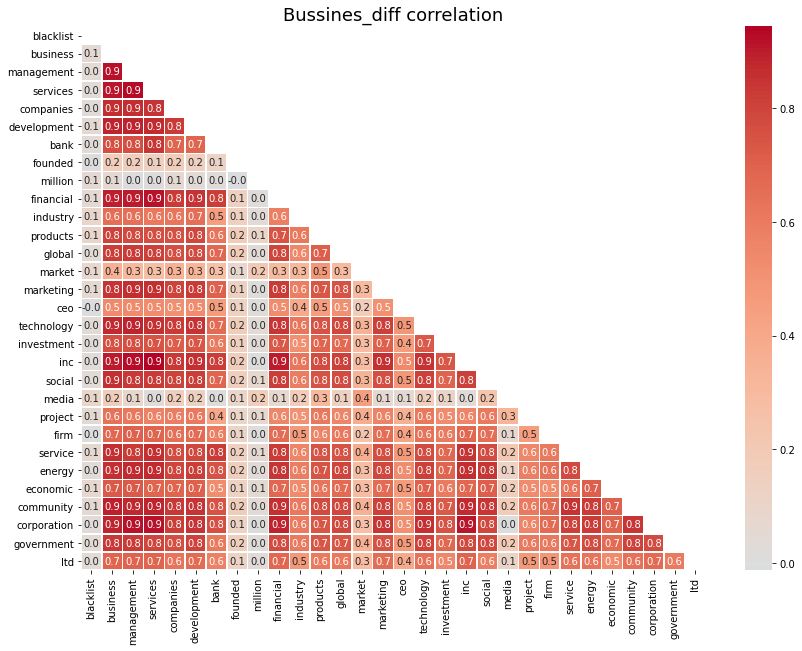

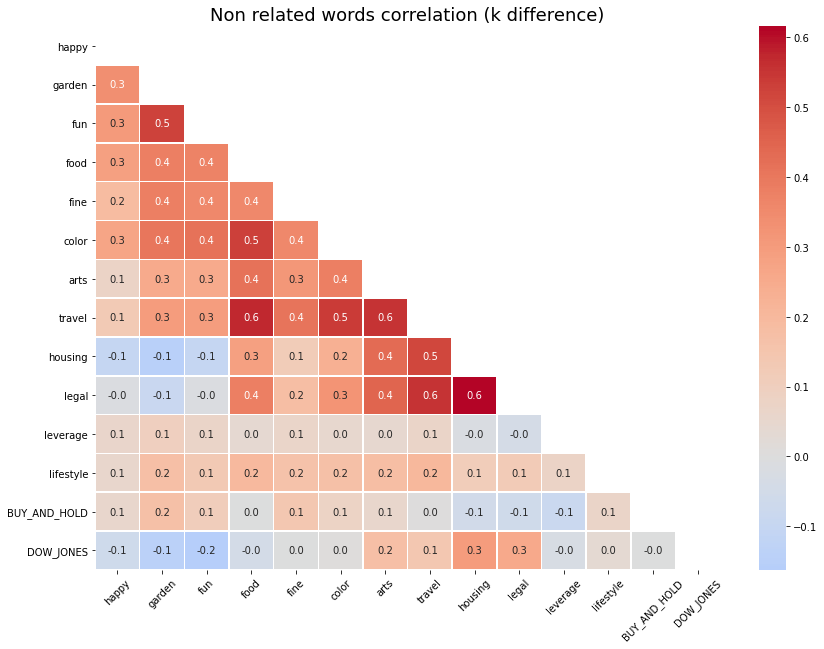

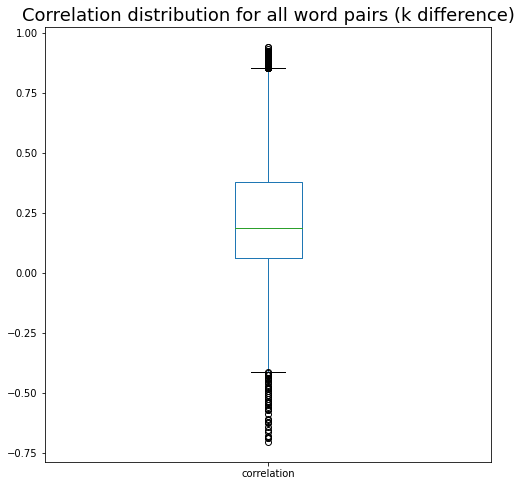

In [11]:
corr = trends_df_train_diff[politics1].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

fig, ax = plt.subplots(figsize=(14,10))
ax.set_title("Politics1_diff correlation", fontsize=18)
sns.heatmap(corr, mask=mask, cmap="coolwarm", center=0, linewidths=0.5, annot=True, fmt=".1f", ax=ax);
plt.xticks(rotation=90);


corr = trends_df_train_diff[politics2].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

fig, ax = plt.subplots(figsize=(14,10))
ax.set_title("Politics2_diff correlation", fontsize=18)
sns.heatmap(corr, mask=mask, cmap="coolwarm", center=0, linewidths=0.5, annot=True, fmt=".1f", ax=ax);
plt.xticks(rotation=90);


corr = trends_df_train_diff[business].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

fig, ax = plt.subplots(figsize=(14,10))
ax.set_title("Bussines_diff correlation", fontsize=18)
sns.heatmap(corr, mask=mask, cmap="coolwarm", center=0, linewidths=0.5, annot=True, fmt=".1f", ax=ax);
plt.xticks(rotation=90);

non_related_words = ["happy", "garden", "fun",
                     "food", "fine", "color",
                     "arts", "travel", "housing",
                     "legal", "leverage", "lifestyle",
                     "BUY_AND_HOLD", "DOW_JONES"]

corr = trends_df_train_diff[non_related_words].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

fig, ax = plt.subplots(figsize=(14,10))
ax.set_title("Non related words correlation (k difference)", fontsize=18)
sns.heatmap(corr, mask=mask, cmap="coolwarm", center=0, linewidths=0.5, annot=True, fmt=".1f", ax=ax);
plt.xticks(rotation=45);

corr = trends_df_train_diff.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
corr_df = pd.DataFrame(corr.mask(cond=mask).values.flatten()).dropna()
corr_df.columns = ["correlation"]
fig, ax = plt.subplots(figsize=(8,8))
corr_df.boxplot(ax=ax, grid=False);
ax.set_title(r"Correlation distribution for all word pairs (k difference)", fontsize=18);

## Properties of the transformed trend series

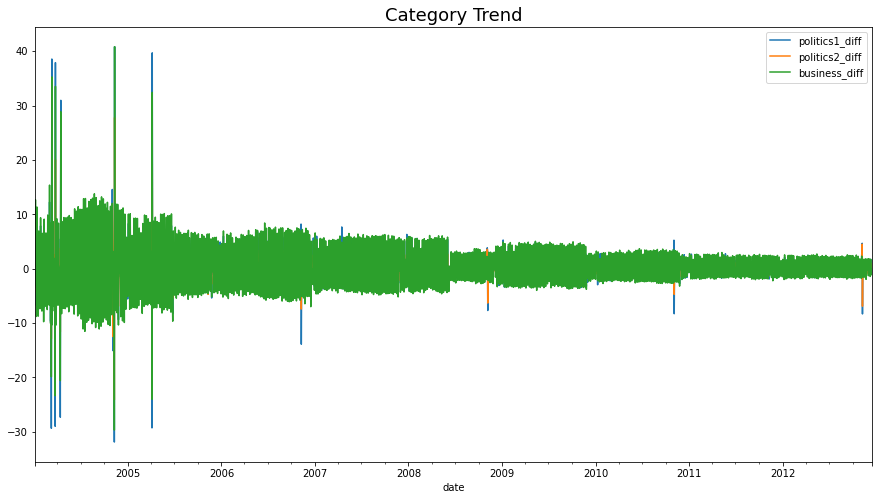

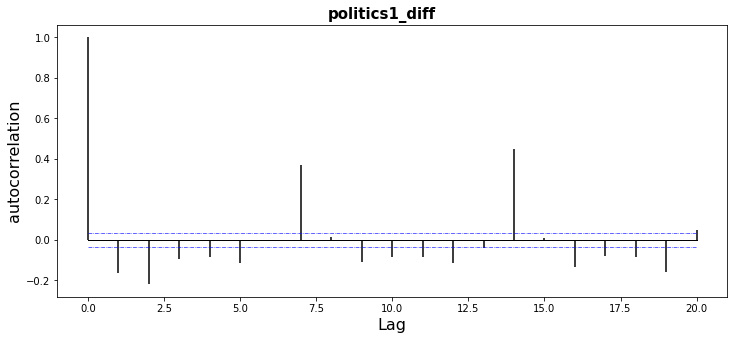

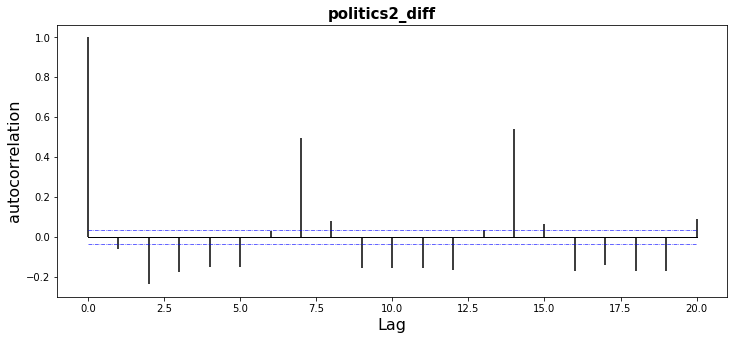

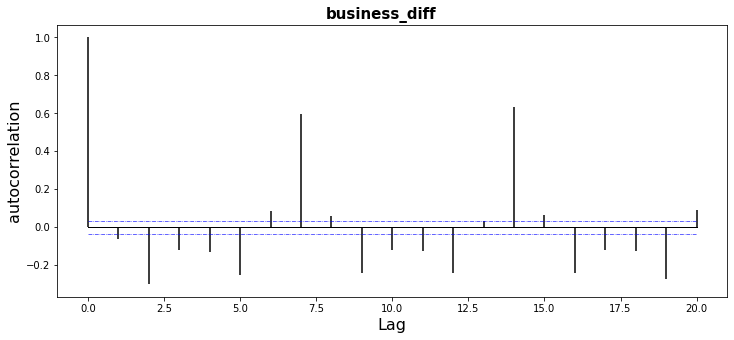

In [12]:
politics1_ts = trends_df_train_diff[politics1].mean(1)
politics1_ts.name = "politics1_diff"
politics2_ts = trends_df_train_diff[politics2].mean(1)
politics2_ts.name = "politics2_diff"
business_ts = trends_df_train_diff[business].mean(1)
business_ts.name = "business_diff"

fig, ax = plt.subplots(figsize=(15,8))
politics1_ts.plot(ax=ax);
politics2_ts.plot(ax=ax);
business_ts.plot(ax=ax);
ax.set_title("Category Trend", fontsize=18);
ax.legend(loc="best");

plot_acf(politics1_ts, lag_range=21, out_path=None)
plot_acf(politics2_ts, lag_range=21, out_path=None)
plot_acf(business_ts, lag_range=21, out_path=None)

## Simple Regression

We use the $k$ trend difference on day t to predict returs on the day t+1 using a simple linear regression. In other words, we assume that:

\begin{equation}
Y_t = \beta_0 + \beta_1 {D^{w}}_{t-1} + \epsilon_t 
\end{equation}

where $Y_t$ is the return of an instrument at day $t$ and $\epsilon_t \thicksim N(0, \sigma^2)$.

In [13]:
# Merging trend diff data and market data
# We shift return information in one day
merged_df = pd.merge_asof(trends_df_train_diff, close, left_index=True, right_index=True)
merged_df.loc[:, "es1_returns"] = merged_df.es1_returns.shift(-1)
merged_df = merged_df.dropna()

# Defining category features
merged_df.loc[:, "politics1_diff"] = merged_df[politics1].mean(1)
merged_df.loc[:, "politics2_diff"] = merged_df[politics2].mean(1)
merged_df.loc[:, "business_diff"] = merged_df[business].mean(1)
columns = [return_column, "politics1_diff", "politics2_diff", "business_diff"] + word_features
merged_df = merged_df[columns]


display(Markdown("### Merged data (training: 2004 -- 2012)"))
display(HTML(merged_df.head(5).to_html()))
display(Markdown("#### data shape = {}".format(merged_df.shape)))

### Merged data (training: 2004 -- 2012)

,es1_returns,politics1_diff,politics2_diff,business_diff,BUY_AND_HOLD,DOW_JONES,act,arts,bank,banking,blacklist,bonds,bubble,business,buy,cancer,car,carolina,case,cash,ceo,chance,college,color,committee,community,companies,conflict,consume,consumption,conty,corporation,council,county,court,crash,credit,crisis,culture,debt,default,democratic,derivatives,development,district,dividend,dow_jones,earnings,earths,economic,economics,economy,elected,election,elections,energy,environment,fed,federal,finance,financial,fine,firm,fond,food,forex,founded,freedom,fun,gain,gains,garden,georgia,global,gold,government,governor,greed,growth,happy,headlines,health,hedge,holiday,home,house,housing,illinois,inc,industry,inflation,invest,investment,judge,justice,kentucky,kitchen,labor,law,legal,leverage,lifestyle,loss,ltd,management,market,marketing,markets,marriage,massachusetts,media,members,metals,million,minister,ministry,missouri,money,movement,movie,nasdaq,notability,nyse,office,ohio,oil,opportunity,ore,party,pennsylvania,police,political,politics,portfolio,present,president,products,profit,project,rare,religion,representatives,republican,restaurant,return,returns,revenue,rich,rights,ring,risk,seats,secretary,security,sell,selling,senate,served,service,services,short,social,society,stats,stock,stocks,success,technology,tennessee,texas,tourism,trader,train,transaction,travel,unemployment,union,vermont,vermount,virginia,voter,voters,votes,war,washington,water,william,winsconsin,wisconsin,world,york
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2004-01-05,0.001782,0.866667,0.100000,1.200000,-1.0,0.0,3.0,3.0,-7.0,-3.0,0.0,-1.0,-3.0,1.0,-10.0,6.0,-2.0,-4.0,0.0,0.0,3.0,-1.0,32.0,7.0,1.0,38.0,1.0,-2.0,-1.0,2.0,0.0,-3.0,1.0,4.0,1.0,4.0,2.0,-1.0,2.0,1.0,-2.0,1.0,-2.0,0.0,27.0,0.0,1.0,2.0,1.0,1.0,2.0,-1.0,1.0,1.0,1.0,-7.0,2.0,-1.0,-4.0,0.0,1.0,-7.0,4.0,0.0,-4.0,-1.0,2.0,0.0,5.0,1.0,-1.0,-3.0,-8.0,-2.0,3.0,4.0,3.0,0.0,-2.0,-4.0,0.0,-1.0,1.0,0.0,-13.0,-7.0,0.0,-7.0,2.0,-2.0,3.0,0.0,2.0,2.0,-3.0,0.0,-4.0,-2.0,6.0,5.0,-1.0,0.0,1.0,-1.0,10.0,-3.0,4.0,0.0,15.0,-2.0,0.0,-1.0,-2.0,-1.0,0.0,3.0,0.0,0.0,3.0,-10.0,1.0,0.0,1.0,-8.0,-11.0,-1.0,1.0,1.0,-11.0,-5.0,-2.0,-3.0,3.0,1.0,-1.0,3.0,2.0,0.0,-3.0,0.0,0.0,0.0,1.0,-8.0,-2.0,1.0,-2.0,1.0,-2.0,2.0,-4.0,-2.0,-1.0,5.0,-4.0,-4.0,0.0,1.0,-9.0,6.0,-2.0,-4.0,1.0,-2.0,3.0,0.0,0.0,-3.0,-2.0,-4.0,4.0,4.0,-8.0,2.0,3.0,-6.0,-6.0,-4.0,-1.0,1.0,1.0,1.0,1.0,4.0,-1.0,3.0,5.0,-1.0,1.0,4.0,-15.0
2004-01-06,0.003123,9.233333,6.033333,12.666667,0.0,1.0,10.0,1.0,37.0,5.0,0.0,-1.0,1.0,34.0,-5.0,4.0,-4.0,10.0,0.0,1.0,-1.0,0.0,-11.0,-2.0,5.0,-1.0,13.0,1.0,1.0,-4.0,1.0,27.0,8.0,25.0,20.0,-4.0,19.0,1.0,4.0,-1.0,2.0,-2.0,1.0,14.0,4.0,0.0,0.0,-2.0,0.0,4.0,2.0,3.0,-1.0,2.0,0.0,13.0,2.0,4.0,29.0,11.0,18.0,2.0,-1.0,2.0,5.0,1.0,-1.0,-1.0,-6.0,-1.0,0.0,1.0,24.0,9.0,-10.0,11.0,1.0,0.0,5.0,2.0,0.0,40.0,0.0,7.0,0.0,6.0,1.0,14.0,26.0,7.0,-2.0,1.0,0.0,-1.0,4.0,2.0,-6.0,5.0,14.0,6.0,0.0,1.0,-2.0,6.0,23.0,10.0,8.0,2.0,-17.0,10.0,-1.0,1.0,2.0,1.0,-2.0,0.0,5.0,-2.0,-2.0,-28.0,0.0,0.0,0.0,46.0,33.0,4.0,-2.0,-1.0,6.0,13.0,5.0,5.0,-1.0,2.0,0.0,5.0,8.0,3.0,10.0,-2.0,-2.0,2.0,1.0,17.0,-7.0,0.0,6.0,0.0,5.0,-13.0,8.0,1.0,12.0,17.0,0.0,4.0,4.0,-1.0,30.0,34.0,1.0,23.0,8.0,1.0,5.0,0.0,1.0,19.0,4.0,18.0,-2.0,-4.0,-1.0,0.0,8.0,10.0,21.0,6.0,0.0,21.0,0.0,0.0,-1.0,-12.0,33.0,9.0,2.0,0.0,11.0,-7.0,29.0
2004-01-07,0.003556,-3.433333,-0.666667,-3.066667,0.0,-1.0,-4.0,-4.0,-8.0,-1.0,1.0,2.0,2.0,-1.0,-2.0,0.0,-5.0,-9.0,-1.0,-3.0,-1.0,0.0,-2.0,1.0,-3.0,-10.0,-4.0,1.0,-1.0,2.0,-1.0,-12.0,0.0,-13.0,-6.0,-4.0,-8.0,-1.0,-3.0,1.0,-1.0,0.0,0.0,-5.0,-1.0,-1.0,-1.0,0.0,0.0,1.0,-2.0,1.0,0.0,-2.0,1.0,0.0,-2.0,0.0,2.0,-4.0,-2.0,1.0,-1.0,-1.0,-1.0,0.0,1.0,1.0,-4.0,0.0,0.0,-1.0,-10.0,1.0,-1.0,2.0,-1.0,0.0,-2.0,3.0,0.0,-9.0,0.0,-1.0,-9.0,0.0,2.0,-2.0,-6.0,-3.0,0.0,-2.0,0.0,1.0,1.0,0.0,0.0,1.0,-6.0,-1.0,0.0,-2.0,1.0,-2.0,-5.0,-2.0,-3.0,-1.0,

#### data shape = (3268, 191)

## Plotting the results of each simple linear regression model in the IS data

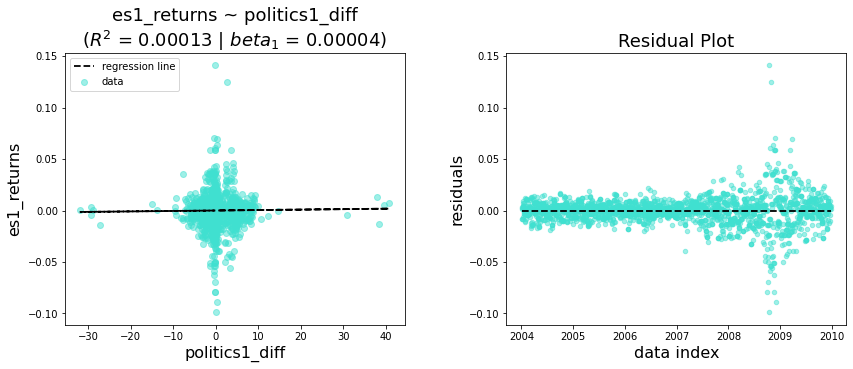

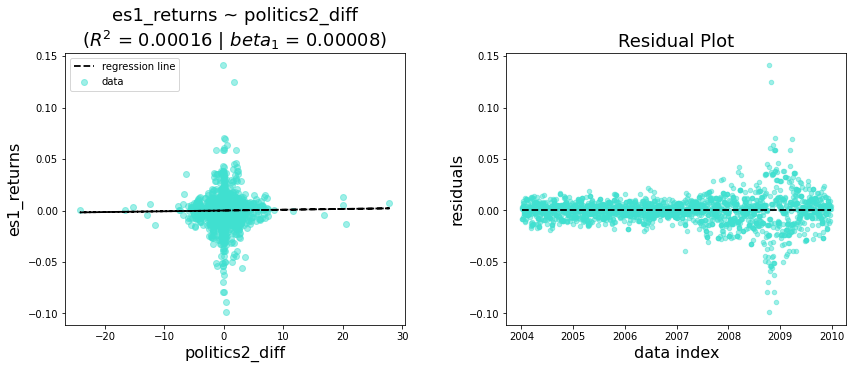

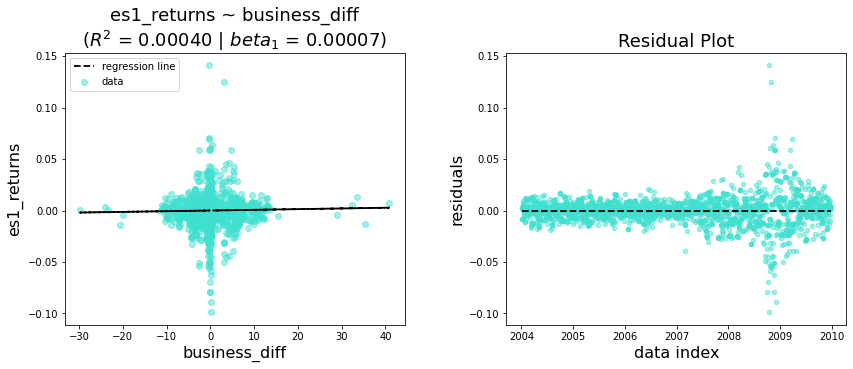

In [14]:
tscv = TimeSeriesSplit(n_splits=2)
for train_index, test_index in tscv.split(merged_df):
    df_train = merged_df.iloc[train_index]
    df_test = merged_df.iloc[test_index]


simple_lr_plot(df=df_train,
               target_column=return_column,
               feature_column="politics1_diff")

simple_lr_plot(df=df_train,
               target_column=return_column,
               feature_column="politics2_diff")

simple_lr_plot(df=df_train,
               target_column=return_column,
               feature_column="business_diff")